# need to fill in any routes with BOTH missing (known) length AND route (so that we can have a guesstimate for all)

# Import packages and data

In [25]:
# note that the order of points in GeoPandas is longitude, latitude 
# (opposite order from that of many data sets)

import geopandas
import shapely.geometry
import shapely.ops
import pyproj
import pandas

import time
import numpy

import pygsheets
import pathlib

import glob

import EEZ file

In [26]:
# from https://www.marineregions.org/downloads.php
# in the section "Marine and land zones: the union of world country boundaries and EEZ's"
#eez_file = '/Users/baird/Dropbox/_gis-data/eez/EEZ_land_union_v2_201410/EEZ_land_v2_201410.shp'
eez_file = '/Users/baird/Dropbox/_gis-data/eez/EEZ_land_union_v3_202003/EEZ_Land_v3_202030.shp'

eez_and_land_boundaries_gdf = geopandas.read_file(eez_file)
eez_and_land_boundaries_gdf = eez_and_land_boundaries_gdf.set_index('UNION')
#eez_4087 = eez_and_land_boundaries.to_crs('epsg:4087')

In [27]:
pandas.DataFrame(eez_and_land_boundaries_gdf.index)#.to_excel('EEZ_unions.xlsx')#to_list()

,UNION
0,Estonia
1,Mayotte
2,Overlapping claim Qatar / Saudi Arabia / Unite...
3,Cameroon
4,Finland
...,...
318,Joint regime area Croatia / Slovenia
319,Joint regime area United States / Russia
320,Australia
321,Protected Zone established under the Torres St...


In [28]:
eez_and_land_boundaries_gdf.MRGID_EEZ

UNION
Estonia                                                           5675.0
Mayotte                                                          48944.0
Overlapping claim Qatar / Saudi Arabia / United Arab Emirates    50170.0
Cameroon                                                          8475.0
Finland                                                           5676.0
                                                                  ...   
Joint regime area Croatia / Slovenia                             50167.0
Joint regime area United States / Russia                         48978.0
Australia                                                         8323.0
Protected Zone established under the Torres Strait Treaty        21798.0
Turkmenistan                                                     26523.0
Name: MRGID_EEZ, Length: 323, dtype: float64

### special cases for EEZs (Hong Kong, Macao...)

import natural earth data file to pick out hong kong, macao

In [29]:
nat_earth_file = '/Users/baird/Dropbox/_gis-data/_natural_earth_data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'
nat_earth_gdf = geopandas.read_file(nat_earth_file)

# pull out shapely geometry polygons and multipolygons
china_geom = eez_and_land_boundaries_gdf.loc[eez_and_land_boundaries_gdf.index=='China','geometry'].values[0]
hk_geom = nat_earth_gdf.loc[nat_earth_gdf.ADMIN=='Hong Kong S.A.R.']['geometry'].values[0]
macao_geom = nat_earth_gdf.loc[nat_earth_gdf.ADMIN=='Macao S.A.R']['geometry'].values[0]

china_new_geom = china_geom - china_geom.intersection(hk_geom)
china_new_geom = china_new_geom - china_new_geom.intersection(macao_geom)

check that the new geometry is smaller in area

now replace the original china in EEZ file, and add Hong Kong, Macao

In [30]:
empty_row_hk = geopandas.GeoDataFrame([[numpy.nan]*eez_and_land_boundaries_gdf.columns.size],
                             columns=eez_and_land_boundaries_gdf.columns, index=['Hong Kong'])
empty_row_hk['geometry'] = hk_geom

empty_row_macao = geopandas.GeoDataFrame([[numpy.nan]*eez_and_land_boundaries_gdf.columns.size],
                             columns=eez_and_land_boundaries_gdf.columns, index=['Macao'])
empty_row_macao['geometry'] = macao_geom

# add geometries to these rows
eez_and_land_boundaries_gdf = pandas.concat([eez_and_land_boundaries_gdf, empty_row_hk], axis=0)
eez_and_land_boundaries_gdf = pandas.concat([eez_and_land_boundaries_gdf, empty_row_macao], axis=0)
# replace with new version of China
eez_and_land_boundaries_gdf.loc[['China'],'geometry'] = geopandas.GeoDataFrame(index=['China'], geometry=[china_new_geom]).geometry
#geopandas.GeoDataFrame(geometry=[shapely_geo]).geometry.values

/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/geopandas/array.py:1569: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/geopandas/array.py:1569: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


now create a blob for all boundaries

In [31]:
# create one blob for all world land and EEZ boundaries, using Shapely function cascaded_union 
# whatever is left out is, presumably, international waters
# this is used below to determine whether any parts of pipelines are in international waters

if 'world_eez_and_land_boundaries_gdf' not in locals(): # only do this if it hasn't been done already
    world_eez_and_land_boundaries_gdf = shapely.ops.cascaded_union(eez_and_land_boundaries_gdf['geometry'])

#check type, should be multipolygon object
#type(world_eez_and_land_boundaries_gdf)

# import and clean data

In [32]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df(start='A3')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A3')

gas_pipes = gas_pipes.replace('--',numpy.nan)
oil_pipes = oil_pipes.replace('--',numpy.nan)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_30409/1369117324.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gas_pipes = gas_pipes.replace('--',numpy.nan)
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_30409/1369117324.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  oil_pipes = oil_pipes.replace('--',numpy.nan)


In [33]:
region_df_orig = spreadsheet.worksheet('title', 'Country dictionary').get_as_df(start='A2')

## replace eez_and_land_boundaries_gdf country names with the ones we use in GGIT/GOIT, for consistency

In [34]:
rename_eez_df = region_df_orig.copy()
rename_eez_df = rename_eez_df[rename_eez_df['EEZNamesIfDifferent']!='']
rename_eez_dict = dict(zip(rename_eez_df.EEZNamesIfDifferent, rename_eez_df.Country))
eez_and_land_boundaries_gdf.rename(index=rename_eez_dict, inplace=True)

## Specify Oil/NGL or Gas, concatenate if oil_and_gas

In [35]:
all_pipes = pandas.concat([oil_pipes,gas_pipes], axis=0, ignore_index=True)
all_pipes = all_pipes.loc[all_pipes.PipelineName!='']

## get geojson files

In [36]:
geojson_path = '/Users/baird/Google Drive/Shared drives/GEM Shared Drive/Programs/'+\
'Oil & Gas Program/Global Oil and Gas Infrastructure Trackers (GOIT, GGIT)/'+\
'GitHub repositories/GOIT-GGIT-pipeline-routes/data/individual-routes/'

geojson_route_files = glob.glob(geojson_path + '*/' + '?????.geojson')

In [37]:
geojson_route_files.__len__()

5982

In [38]:
geojson_projectids = [str(i).split('/')[-1][:5] for i in geojson_route_files]

missing in sheet but on github

In [39]:
set(all_pipes.ProjectID.tolist())-set(geojson_projectids)

{'P6641', 'P7019'}

missing from github but on sheet

In [40]:
set(geojson_projectids)-set(all_pipes.ProjectID.tolist())

set()

In [41]:
for idx,pid in enumerate(all_pipes.ProjectID.tolist()):
    try:
        file = glob.glob(geojson_path + '*/' + pid + '.geojson')[0]
        file_gdf = geopandas.read_file(file)
        file_geometry_dissolved = file_gdf.dissolve().geometry
        all_pipes.loc[all_pipes.ProjectID==pid,'geometry'] = file_geometry_dissolved[0]
    except:
        print(pid," geojson file either doesn't exist or has bad geometry")

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_30409/1012529522.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_pipes.loc[all_pipes.ProjectID==pid,'geometry'] = file_geometry_dissolved[0]


P0168  geojson file either doesn't exist or has bad geometry


/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/shapely/set_operations.py:406: RuntimeWarning: invalid value encountered in create_collection
  collections = lib.create_collection(geometries, GeometryType.GEOMETRYCOLLECTION)
/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/shapely/set_operations.py:406: RuntimeWarning: invalid value encountered in create_collection
  collections = lib.create_collection(geometries, GeometryType.GEOMETRYCOLLECTION)
/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/fiona/collection.py:293: FeatureWarning: Empty field name at index 0
  self._schema = self.session.get_schema()
/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/geopandas/geodataframe.py:652: UserWarning: Empty field name at index 0
  for feature in features_lst:


P6641  geojson file either doesn't exist or has bad geometry


/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/shapely/set_operations.py:406: RuntimeWarning: invalid value encountered in create_collection
  collections = lib.create_collection(geometries, GeometryType.GEOMETRYCOLLECTION)
/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/shapely/set_operations.py:419: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


P7019  geojson file either doesn't exist or has bad geometry


In [42]:
# remove any NaN geometries that were part of the exception above
all_pipes = all_pipes.loc[~all_pipes.geometry.isnull()]

In [43]:
all_pipes_gdf = geopandas.GeoDataFrame(all_pipes, geometry=all_pipes.geometry)

<Axes: >

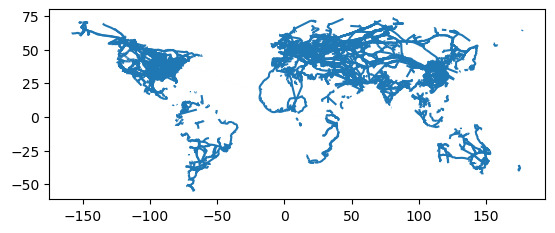

In [44]:
all_pipes_gdf.geometry.plot()

In [45]:
geodetic_computation = pyproj.Geod(ellps="WGS84")

## calculating length, collecting in `all_pipes_gdf_withroutes`

In [46]:
all_pipes_gdf_withroute = all_pipes_gdf.loc[~all_pipes_gdf.geometry.is_empty]#[['ProjectID','geometry']]
all_pipes_gdf_withroute['LengthEstimateKm'] = numpy.nan
all_pipes_gdf_withroute = all_pipes_gdf_withroute.reset_index(drop=True)

geodetic_computation = pyproj.Geod(ellps="WGS84")
for idx,row in all_pipes_gdf_withroute.iterrows():
    #print(idx)
    all_pipes_gdf_withroute.at[idx, 'LengthEstimateKm'] = geodetic_computation.geometry_length(all_pipes_gdf_withroute.iloc[idx].geometry)/1000

/Users/baird/miniconda3/envs/gem/lib/python3.11/site-packages/geopandas/geodataframe.py:1581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

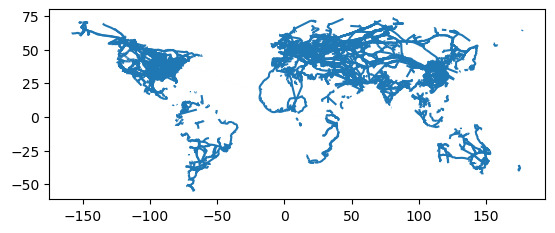

In [47]:
all_pipes_gdf.geometry.plot()

In [48]:
all_pipes_gdf_noroute = all_pipes_gdf.loc[(all_pipes_gdf.geometry.is_empty)&
                                          (~all_pipes_gdf.LengthKnownKm.isnull())&
                                          (all_pipes_gdf.LengthKnownKm>0)]#[['ProjectID','geometry']]

In [49]:
all_pipes_gdf_noroute.geometry

153     GEOMETRYCOLLECTION EMPTY
309     GEOMETRYCOLLECTION EMPTY
310     GEOMETRYCOLLECTION EMPTY
312     GEOMETRYCOLLECTION EMPTY
314     GEOMETRYCOLLECTION EMPTY
                  ...           
5987    GEOMETRYCOLLECTION EMPTY
5991    GEOMETRYCOLLECTION EMPTY
5992    GEOMETRYCOLLECTION EMPTY
5993    GEOMETRYCOLLECTION EMPTY
5994    GEOMETRYCOLLECTION EMPTY
Name: geometry, Length: 823, dtype: geometry

# save results by pipeline excel file

In [50]:
all_pipes_gdf_withroute[['ProjectID','LengthEstimateKm']].to_excel('estimate-length-results-by-pipeline.xlsx')

# calculate length within country

In [51]:
def pipeline_within_country(pipeline_ls, 
                            pipeline_name, 
                            segment_name, 
                            project_id, 
                            results_by_country, 
                            status, 
                            fuel, 
                            length, 
                            # length_total,
                            remainders, 
                            international):
    '''
    Iterate through all countries, to see if the specified pipeline 
    
    is within each country (at least partially).
    
    If there is a portion within a given country, 
    saves the country name and length of pipeline to a df
    '''
    
    #print(pipeline_name, '--', segment_name)
    
    pipeline_remainders = pipeline_ls # initialize
    # will progressively remove pieces of the pipeline, 
    # as they intersect with each country's land mass
    geodetic_computation = pyproj.Geod(ellps="WGS84") # initialize
    length_total = geodetic_computation.geometry_length(pipeline_ls)/1000 # units km
    
    for country in eez_and_land_boundaries_gdf.index:
        
        country_geom = eez_and_land_boundaries_gdf.loc[country, 'geometry']
        
        if country_geom.intersects(pipeline_ls)==True:
            #print(country)
            pipeline_intersection = pipeline_ls.intersection(country_geom)
            pipeline_remainders = pipeline_remainders.difference(country_geom)
            
            length_per_country = geodetic_computation.geometry_length(pipeline_intersection)/1000 # units km
            length_per_country_fract = length_per_country / length_total
            
            one_result = (
                pipeline_name, 
                segment_name,
                project_id,
                country, 
                length_per_country, 
                length_per_country_fract,
                status,
                fuel,
                # length,
                length_total)
            one_result_df = pandas.DataFrame(one_result).T
            one_result_df.columns = ['pipeline_name', 'segment_name', 'project_id', 'country', 
                                     'length_per_country', 'length_per_country_fract', 
                                     'status', 'fuel', 'length']
            
            # results_by_country = results_by_country.append(
            #     pandas.DataFrame(one_result_df), 
            #     sort=False)
            results_by_country = pandas.concat([results_by_country,
                one_result_df], axis=0, ignore_index=True, sort=False)
            
        else:
            pass

    results_by_country = results_by_country.reset_index(drop=True)
        
    if pipeline_remainders.is_empty==False:       
        remainders_length = geodetic_computation.geometry_length(pipeline_remainders)/1000 # units km
        
        if remainders_length > 0.01: # units: km
            remainders_tuple = (pipeline_name, segment_name, project_id, remainders_length, pipeline_remainders)
            remainders = pandas.DataFrame(remainders_tuple).T
            #print(remainders)
            if pipeline_name == 'TransColorado Gas Pipeline':
                print(remainders_tuple)
                print(remainders)
            remainders.columns = ['pipeline_name', 'segment_name', 'project_id', 'length', 'geometry']
            print()
            print(f"for {pipeline_name}, pipeline_remainders.is_empty==False") # for db
            print(f"remainders_length: {remainders_length}") # for db
            print()
        
    else:
#         print(f"for {pipeline_name}, pipeline_remainders.is_empty is NOT False") # for db
        pass
    
    # alternative method: pipeline that's in international waters (not in world_eez_and_land_boundaries_gdf)
    #print(pipeline_name,segment_name)
    international_pipeline = pipeline_ls.difference(world_eez_and_land_boundaries_gdf)
    if international_pipeline.is_empty==False:
        international_length = geodetic_computation.geometry_length(international_pipeline)/1000 # units km
        international_tuple = (pipeline_name, international_length, international_pipeline)
        international = pandas.DataFrame(international_tuple).T
        international.columns = ['pipeline_name', 'length', 'geometry']
    else:
        pass
    
    return results_by_country, remainders, international

In [52]:
# calculate length by country
# get coord_str for each pipeline that has route coordinates

# choose pipes_withroute_df to process
results_by_country = pandas.DataFrame(
    columns=['pipeline_name', 
             'segment_name', 
             'project_id', 
             'country', 
             'length_per_country', 
             'status', 
             'fuel', 
             'length',
             # 'length_total'
            ]
)

remainders = geopandas.GeoDataFrame()
international = geopandas.GeoDataFrame()

for sel_index in all_pipes_gdf_withroute.index:
    pipeline_name = all_pipes_gdf_withroute.at[sel_index, 'PipelineName']
    segment_name = all_pipes_gdf_withroute.at[sel_index, 'SegmentName']
    project_id = all_pipes_gdf_withroute.at[sel_index, 'ProjectID']
    
    print(pipeline_name, segment_name, project_id)
    
    status = all_pipes_gdf_withroute.at[sel_index, 'Status']
    fuel = all_pipes_gdf_withroute.at[sel_index, 'Fuel']
    length = all_pipes_gdf_withroute.at[sel_index, 'LengthKnownKm']

    pipeline_ls = all_pipes_gdf_withroute.at[sel_index, 'geometry']
    
    results_by_country, remainders, international = pipeline_within_country(
        pipeline_ls, 
        pipeline_name, 
        segment_name, 
        project_id, 
        results_by_country, 
        status, 
        fuel, 
        length,
        # length_total,
        remainders, 
        international)

Alberta Clipper Oil Pipeline  P0001
Athabasca Oil Pipeline  P0002
Bakken Expansion Pipeline  P0004
Cochin Pipeline System  P0005
Explorer Pipeline  P0006
Corridor Oil Pipeline  P0007
Enbridge Line 10 Oil Pipeline  P0008
Enbridge Line 11 Oil Pipeline  P0009
Enbridge Line 1 Oil Pipeline  P0010
Enbridge Line 2 Oil Pipeline  P0011
Enbridge Line 3 Oil Pipeline  P0012
Enbridge Line 4 Oil Pipeline  P0013
Enbridge Line 5 Pipeline  P0014
Enbridge Line 6 Oil Pipeline  P0015
Enbridge Line 65 Oil Pipeline  P0016
Enbridge Line 7 Oil Pipeline  P0017
Enbridge Line 9 Oil Pipeline  P0018
Energy East Oil Pipeline  P0019
Express Oil Pipeline System  P0020
Grand Rapids Oil Pipeline  P0021
Heartland Oil Pipeline  P0022
Horizon Crude Oil Pipeline  P0023
Keystone Oil Pipeline Mainline (Phase 1) P0024
Keystone XL Oil Pipeline  P0025
Husky Midstream Mainline System Lloydminster-Hardisty Oil Pipeline P0026
Norman Wells Oil Pipeline  P0027
Saskatchewan Oil Pipeline  P0029
SEKCO Oil Pipeline  P0030
Southern Acces

# now evenly distribute pipelines without routes across countries

In [53]:
results_by_country_noroute = pandas.DataFrame(
    columns=['pipeline_name', 'segment_name', 'project_id', 'country', 'length_per_country', 'status', 'fuel', 'length']
)

for sel_index in all_pipes_gdf_noroute.index:

    pipeline_name = all_pipes_gdf_noroute.at[sel_index, 'PipelineName']
    segment_name = all_pipes_gdf_noroute.at[sel_index, 'SegmentName']
    project_id = all_pipes_gdf_noroute.at[sel_index, 'ProjectID']
    status = all_pipes_gdf_noroute.at[sel_index, 'Status']
    fuel = all_pipes_gdf_noroute.at[sel_index, 'Fuel']
    length = all_pipes_gdf_noroute.at[sel_index, 'LengthKnownKm']
    
    ncountries = all_pipes_gdf_noroute.at[sel_index, 'NumberOfCountries']

    # if it crosses into more than one country
    if ncountries>1:

        country_list = all_pipes_gdf_noroute.at[sel_index, 'Countries'].split(',')
        country_list = [i.strip() for i in country_list]

        for country in country_list:
            length_per_country = length/country_list.__len__()
            length_per_country_fract = 1/country_list.__len__()

            one_result = (
                pipeline_name, 
                segment_name,
                project_id,
                country, 
                length_per_country, 
                length_per_country_fract,
                status,
                fuel,
                length)
            one_result_df = pandas.DataFrame(one_result).T
            one_result_df.columns = ['pipeline_name', 'segment_name', 'project_id', 'country', 
                                     'length_per_country', 'length_per_country_fract', 
                                     'status', 'fuel', 'length']

            results_by_country_noroute = pandas.concat([results_by_country_noroute,
            pandas.DataFrame(one_result_df)], axis=0,
            sort=False)

    else:
        country = all_pipes_gdf_noroute.at[sel_index, 'Countries']

        length_per_country = length
        length_per_country_fract = 1.0

        one_result = (
            pipeline_name, 
            segment_name,
            project_id,
            country, 
            length_per_country, 
            length_per_country_fract,
            status,
            fuel,
            length)
        one_result_df = pandas.DataFrame(one_result).T
        one_result_df.columns = ['pipeline_name', 'segment_name', 'project_id', 'country', 
                                 'length_per_country', 'length_per_country_fract', 
                                 'status', 'fuel', 'length']

        results_by_country_noroute = pandas.concat([results_by_country_noroute,
            pandas.DataFrame(one_result_df)], axis=0,
            sort=False)

In [54]:
results_by_country_combined = pandas.concat([results_by_country,
                                             results_by_country_noroute],
                                            axis=0, sort=False)

# Clean and export results

In [55]:
# export length estimates by country and pipeline
results_by_country_combined = results_by_country_combined[['pipeline_name','segment_name',
                                         'project_id', 'country', 'length_per_country', 
                                         'length_per_country_fract']]
results_by_country_combined.rename(columns={
                                    'pipeline_name':'PipelineName',
                                    'segment_name':'SegmentName',
                                    'project_id':'ProjectID',
                                    'country':'Country',
                                    'length_per_country':'LengthEstimateKmByCountry',
                                    # 'length':'LengthEstimateKm',
                                    'length_per_country_fract':'LengthPerCountryFraction'}, inplace=True)

# change Alaska to United States
# change Canary Islands to Spain
results_by_country_combined['Country'].replace('Alaska', 'United States', inplace=True)
results_by_country_combined['Country'].replace('Canary Islands', 'Morocco', inplace=True) # FOR Nigeria-Morocco Pipeline ONLY!!
results_by_country_combined['Country'].replace('Senkaku Islands', 'Japan', inplace=True)

results_by_country_combined.sort_values('ProjectID', inplace=True)

results_by_country_combined.to_excel('estimate-length-results-by-country.xlsx')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_30409/2571146111.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_by_country_combined['Country'].replace('Alaska', 'United States', inplace=True)
/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_30409/2571146111.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate o